In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

folder_path = r'C:\Users\donat\Downloads\Paid Price UK data'

# Get a list of all CSV files in the folder
files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Create an empty list to store individual DataFrames
dataframes = []
registry_names = ['id', 'price', 'date', 'postcode', 'property_type', 'old/new', 'duration', 'PAON', 
                  'SAON', 'street', 'locality', 'city', 'district', 'county', 'ppd category', 'record status']

# Iterate over each file and read it as a DataFrame
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, names=registry_names)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

print(df.head())  # Display the first few rows of the combined DataFrame

                                       id   price              date  postcode  \
0  {726BF13A-993E-0A46-E053-6C04A8C01D0D}   75000  2018-06-20 00:00  DL13 4BA   
1  {726BF13A-993F-0A46-E053-6C04A8C01D0D}  115000  2018-07-13 00:00  DL17 9LB   
2  {726BF13A-9940-0A46-E053-6C04A8C01D0D}   24000  2018-04-10 00:00   SR7 9AG   
3  {726BF13A-9941-0A46-E053-6C04A8C01D0D}   56000  2018-06-22 00:00   DL5 5PS   
4  {726BF13A-9942-0A46-E053-6C04A8C01D0D}  220000  2018-05-25 00:00  DL16 7HE   

  property_type old/new duration PAON SAON          street         locality  \
0             T       N        F   21  NaN      HIGHFIELDS          TOW LAW   
1             S       N        F    4  NaN        THE LANE   WEST CORNFORTH   
2             F       N        L  20B  NaN   WOODS TERRACE           MURTON   
3             T       N        F    6  NaN     HEILD CLOSE              NaN   
4             D       N        F   25  NaN  BECKWITH CLOSE  KIRK MERRINGTON   

              city       district     

In [13]:
df['city'] = df['city'].str.title()
df['district'] = df['district'].str.title()
df['county'] = df['county'].str.title()
df['street'] = df['street'].str.title()

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_year'] = df['date'].dt.strftime('%m/%Y')
df['date'] = df['date'].dt.strftime('%d/%m/%Y')

df['property_type'] = df['property_type'].replace('F', 'Flat/Maisonette')
df['property_type'] = df['property_type'].replace('T', 'Terraced')
df['property_type'] = df['property_type'].replace('D', 'Detached')
df['property_type'] = df['property_type'].replace('S', 'Semi-Detached')

df['old/new'] = df['old/new'].replace('Y', 'New')
df['old/new'] = df['old/new'].replace('N', 'Old')

df['duration'] = df['duration'].replace('F', 'Freehold')
df['duration'] = df['duration'].replace('L', 'Leasehold')

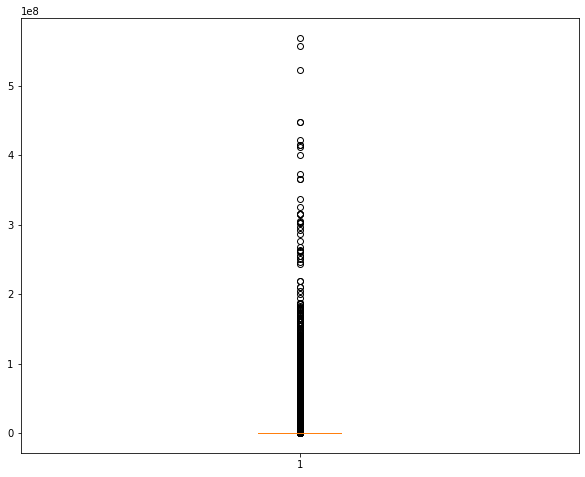

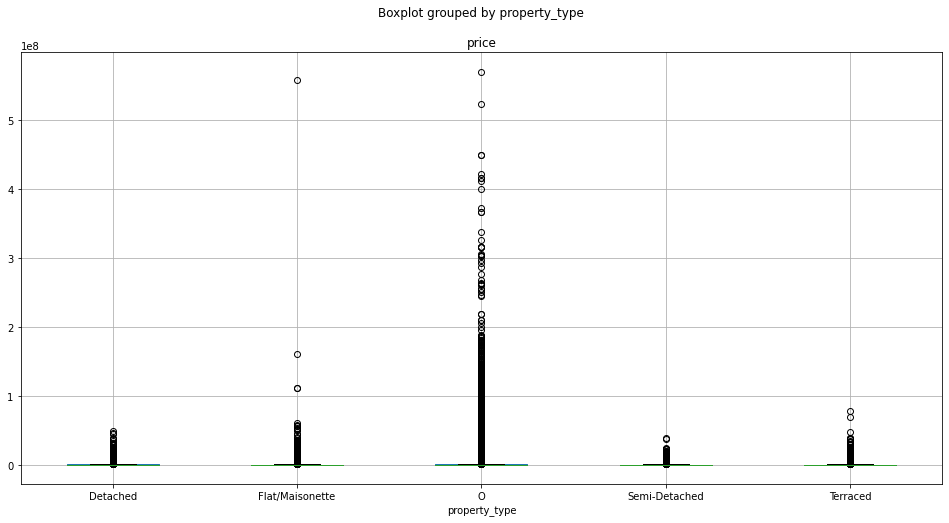

In [14]:
fig = plt.figure(figsize =(10, 8))
plt.boxplot(df['price']);
df.boxplot(column='price', by = 'property_type', figsize = (16,8));

df[df['property_type']=='O']['ppd category'].unique()
df = df[(df['property_type']!='O') & (df['ppd category']!='B')] 

'''
All 'O' type property comes under Additional Price Paid entry meaning they are related to non-standard 
payments. Let's assume we need to seek only standard investments (meaning 'ppd category' = 'A') 
then we can drop the rows belonging to 'ppd category' = 'B'
'''


#create a unique ID for each unique combination of the columns related to the address,
df['address_id'] = pd.factorize(df['PAON'].astype(str) + df['SAON'].astype(str) + df['street'].astype(str) 
                               + df['locality'].astype(str) + df['city'].astype(str) 
                               + df['district'].astype(str) + df['county'].astype(str) 
                               + df['postcode'].astype(str))[0] + 1

#extract = df[df['postcode'] == 'WF1 1EL']

#df_2022 = df[df['year'] == 2022]

<AxesSubplot:xlabel='property_type'>

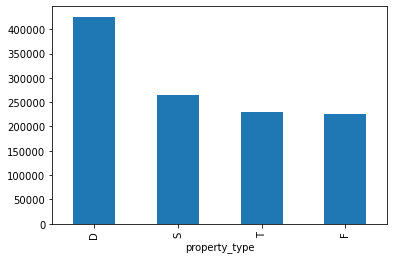

In [16]:
#df_2022['property_type'].value_counts().plot(kind="bar")

# Plot the median price per property type
median_price_per_type = df_2022.groupby('property_type')['price'].median().sort_values(ascending=False)
median_price_per_type.plot(kind='bar')

# I suspect in London where prices are higher than the rest of the UK there are more flats and terraced houses and this pushes up the UK average

<AxesSubplot:xlabel='county'>

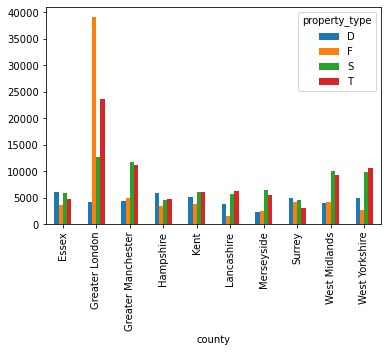

In [17]:
# Get the top 10 counties by transaction count
top_counties = df_2022['county'].value_counts().head(10)

# Filter the DataFrame for the top 10 counties
df_top_counties = df_2022[df_2022['county'].isin(top_counties.index)]

# Calculate the count of property types for the top 10 counties
property_type_counts = df_top_counties.groupby(['county', 'property_type']).size().unstack()

# Plot the count of property types for the top 10 counties
property_type_counts.plot(kind='bar', stacked=False)

<AxesSubplot:xlabel='county'>

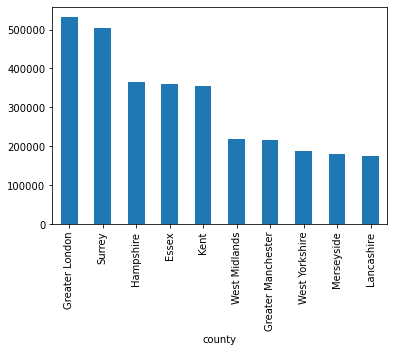

In [23]:
df_top_counties.groupby('county')['price'].median().sort_values(ascending=False).plot(kind='bar')

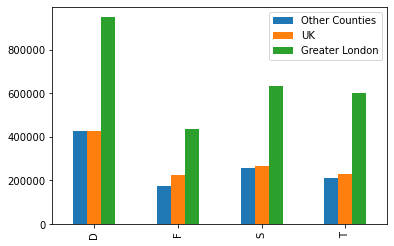

In [31]:
df_noLondon = df_2022[df_2022['county']!='Greater London']
df_London = df_2022[df_2022['county']=='Greater London']

median_price_per_type_noLondon = df_noLondon.groupby('property_type')['price'].median()
median_price_per_type_London = df_London.groupby('property_type')['price'].median()

# Combine the median price data for both Greater London and other counties
combined_median_prices = pd.concat([median_price_per_type_noLondon, median_price_per_type, median_price_per_type_London], axis=1)
combined_median_prices.columns = ['Other Counties', 'UK', 'Greater London']

# Plot the median price per property type comparison
combined_median_prices.plot(kind='bar')

In [39]:
print((combined_median_prices.loc['F', 'UK'] - combined_median_prices.loc['F', 'Other Counties'])/ combined_median_prices.loc['F', 'Other Counties']*100)

27.84090909090909


In [15]:
df_London = df[df['city']=='London']
londonpostcodes = pd.read_csv(r'C:\Users\donat\Downloads\London postcodes.csv', header=0)
#londonpostcodes_var = ['postcode', 'In Use', 'Grid Ref', 'County', 'District', 'Ward', 'District County', 'Ward County', 'Country', 'County Code', 'Costituency']
df_London = df_London.merge(londonpostcodes[['postcode', 'District', 'Ward', 'District Code', 'Ward Code']], on='postcode', how='left')

In [25]:
null_values = df_London['postcode'].isnull().sum()
print(null_values)
df_London.shape
#df_London = df_London.drop(columns=['PAON', 'SAON', 'street', 'locality', 'address_id', 'month', 'month_year', 'year', 'district', 'ppd category', 'record status'])
df_London.to_csv('London housing data.csv')

74


In [5]:
df = df.drop(columns=['PAON', 'SAON', 'street', 'locality', 'address_id', 'month', 'month_year', 'year', 'postcode', 'district', 'ppd category', 'record status'])
df.to_csv('UK housing data.csv')